# Analytics

## Unigrams/Bigrams summary

In [194]:
import string
import json
import pandas as pd
import re
from collections import Counter
from pathlib import Path

import nltk
import matplotlib.pyplot as plt
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords

Parse and convert all data to a Pandas Dataframe

In [195]:
base_path = Path("semeval2017-task8-dataset/rumoureval-data")
sentiment_file = Path("./semeval2017-task8-dataset/traindev/rumoureval-subtaskA-train.json")

with open(sentiment_file, 'r') as f:
    sentiment_dict = json.load(f)

records = []

for topic_dir in base_path.iterdir():
    topic = topic_dir.name

    for tweet_dir in topic_dir.iterdir():
        source_tweet_id = tweet_dir.name
        
        # Add source tweet column
        source_tweet_path = topic_dir / source_tweet_id / "source-tweet" / f"{source_tweet_id}.json"
        with open(source_tweet_path, 'r', encoding='utf-8') as f:
            source_data = json.load(f)
        source_tweet_text = source_data.get('text', '')
        
        replies_dir = tweet_dir / "replies"

        for json_file in replies_dir.glob("*.json"):
            with open(json_file, 'r', encoding='utf-8') as f:
                tweet_data = json.load(f)
            
            tweet_id = str(tweet_data.get('id', ''))
            record = {
                'tweet_id': tweet_id,
                'source_tweet_id': source_tweet_id,
                'source_tweet_text': source_tweet_text,
                'topic': topic,
                'text': tweet_data.get('text', ''),
                'sentiment': sentiment_dict.get(tweet_id),
                'source_tweet_sentiment': sentiment_dict.get(source_tweet_id),
            }
            records.append(record)

df = pd.DataFrame(records)

Check dataframe and sentiment distribution

In [196]:
df.head()

,tweet_id,source_tweet_id,source_tweet_text,topic,text,sentiment,source_tweet_sentiment
0,553549946738446336,553543369604210689,An 11-month old baby is among the hostages at ...,charliehebdo,@PD28 @BklynMiddleton Hashtag #kosher shows lo...,query,support
1,553547724860456961,553543369604210689,An 11-month old baby is among the hostages at ...,charliehebdo,*Mutes Universe*,comment,support
2,553551580801536000,553543369604210689,An 11-month old baby is among the hostages at ...,charliehebdo,@BklynMiddleton rather than being a 'lone-wolf...,query,support
3,553553099470946304,553543369604210689,An 11-month old baby is among the hostages at ...,charliehebdo,@PD28 @BklynMiddleton No problem! Wish it were...,comment,support
4,553544770430464000,553543369604210689,An 11-month old baby is among the hostages at ...,charliehebdo,RT @BklynMiddleton: An 11-month old baby is am...,support,support


In [197]:
print(f"Total tweets: {len(df)}")
print(f"DataFrame shape: {df.shape}")
print(f"Columns: {df.columns.tolist()}")

# Sentiment distribution
if 'sentiment' in df.columns:
    print(df['sentiment'].value_counts(dropna=False))
    print(f"\nTweets with sentiment: {df['sentiment'].notna().sum()}")
    print(f"Tweets without sentiment: {df['sentiment'].isna().sum()}")

Total tweets: 4222
DataFrame shape: (4222, 7)
Columns: ['tweet_id', 'source_tweet_id', 'source_tweet_text', 'topic', 'text', 'sentiment', 'source_tweet_sentiment']
sentiment
comment    2724
support     587
query       330
deny        325
None        256
Name: count, dtype: int64

Tweets with sentiment: 3966
Tweets without sentiment: 256


Remove tweets without sentiment as we cannot train our model with unlabeled data

In [198]:
df = df.dropna(subset=['sentiment'])
if 'sentiment' in df.columns:
    print(f"\nTweets with sentiment: {df['sentiment'].notna().sum()}")
    print(f"Tweets without sentiment: {df['sentiment'].isna().sum()}")


Tweets with sentiment: 3966
Tweets without sentiment: 0


Do some preprocessing to remove unnecessary information (like urls and mentions)

In [199]:
def preprocess_text(text):
    if not isinstance(text, str):
        return ""
    text = re.sub(r'@\w+', '', text)
    text = text.lower()
    text = ' '.join(word for word in text.split() if not word.startswith('http'))
    text = text.translate(str.maketrans('', '', string.punctuation))

    return text

df['processed_text'] = df['text'].apply(preprocess_text)
df['processed_source_text'] = df['source_tweet_text'].apply(preprocess_text) 

In [200]:
df.head()

,tweet_id,source_tweet_id,source_tweet_text,topic,text,sentiment,source_tweet_sentiment,processed_text,processed_source_text
0,553549946738446336,553543369604210689,An 11-month old baby is among the hostages at ...,charliehebdo,@PD28 @BklynMiddleton Hashtag #kosher shows lo...,query,support,hashtag kosher shows lots of journalists are r...,an 11month old baby is among the hostages at t...
1,553547724860456961,553543369604210689,An 11-month old baby is among the hostages at ...,charliehebdo,*Mutes Universe*,comment,support,mutes universe,an 11month old baby is among the hostages at t...
2,553551580801536000,553543369604210689,An 11-month old baby is among the hostages at ...,charliehebdo,@BklynMiddleton rather than being a 'lone-wolf...,query,support,rather than being a lonewolf copycat the fact ...,an 11month old baby is among the hostages at t...
3,553553099470946304,553543369604210689,An 11-month old baby is among the hostages at ...,charliehebdo,@PD28 @BklynMiddleton No problem! Wish it were...,comment,support,no problem wish it werent such a horrible situ...,an 11month old baby is among the hostages at t...
4,553544770430464000,553543369604210689,An 11-month old baby is among the hostages at ...,charliehebdo,RT @BklynMiddleton: An 11-month old baby is am...,support,support,rt an 11month old baby is among the hostages ...,an 11month old baby is among the hostages at t...


Get the Unigrams and Bigrams tokens

In [201]:
try:
    nltk.data.find('corpora/stopwords')
except LookupError:
    nltk.download('stopwords')

stop_words = set(stopwords.words('english'))

unigram_vectorizer = CountVectorizer(
    stop_words=list(stop_words),
    max_features=1000,
    ngram_range=(1, 1)
)

bigram_vectorizer = CountVectorizer(
    stop_words=list(stop_words),
    max_features=1000,
    ngram_range=(2, 2)
)

stance_labels = sorted(df['sentiment'].unique())

ngram_data = {
    'unigrams': {},
    'bigrams': {},
    'top_unigrams_summary': {},
    'top_bigrams_summary': {}
}

for label in stance_labels:
    label_tweets = df[df['sentiment'] == label]
    label_texts = label_tweets['processed_text'].tolist()
    
    # Compute unigrams
    unigram_counts = unigram_vectorizer.fit_transform(label_texts)
    unigram_sums = unigram_counts.sum(axis=0)
    unigram_freq = [(word, unigram_sums[0, idx]) for word, idx in unigram_vectorizer.vocabulary_.items()]
    unigram_freq_sorted = sorted(unigram_freq, key=lambda x: x[1], reverse=True)
    ngram_data['unigrams'][label] = unigram_freq_sorted[:15]
    ngram_data['top_unigrams_summary'][label] = [word for word, _ in unigram_freq_sorted[:5]]

    
    # Compute bigrams
    bigram_counts = bigram_vectorizer.fit_transform(label_texts)
    bigram_sums = bigram_counts.sum(axis=0)
    bigram_freq = [(bigram, bigram_sums[0, idx]) for bigram, idx in bigram_vectorizer.vocabulary_.items()]
    bigram_freq_sorted = sorted(bigram_freq, key=lambda x: x[1], reverse=True)
    ngram_data['bigrams'][label] = bigram_freq_sorted[:15]
    ngram_data['top_bigrams_summary'][label] = [bigram for bigram, _ in bigram_freq_sorted[:5]]

# Create summary DataFrames
summary_unigram_df = pd.DataFrame(ngram_data['top_unigrams_summary'])
summary_bigram_df = pd.DataFrame(ngram_data['top_bigrams_summary'])


Unigram breakdown

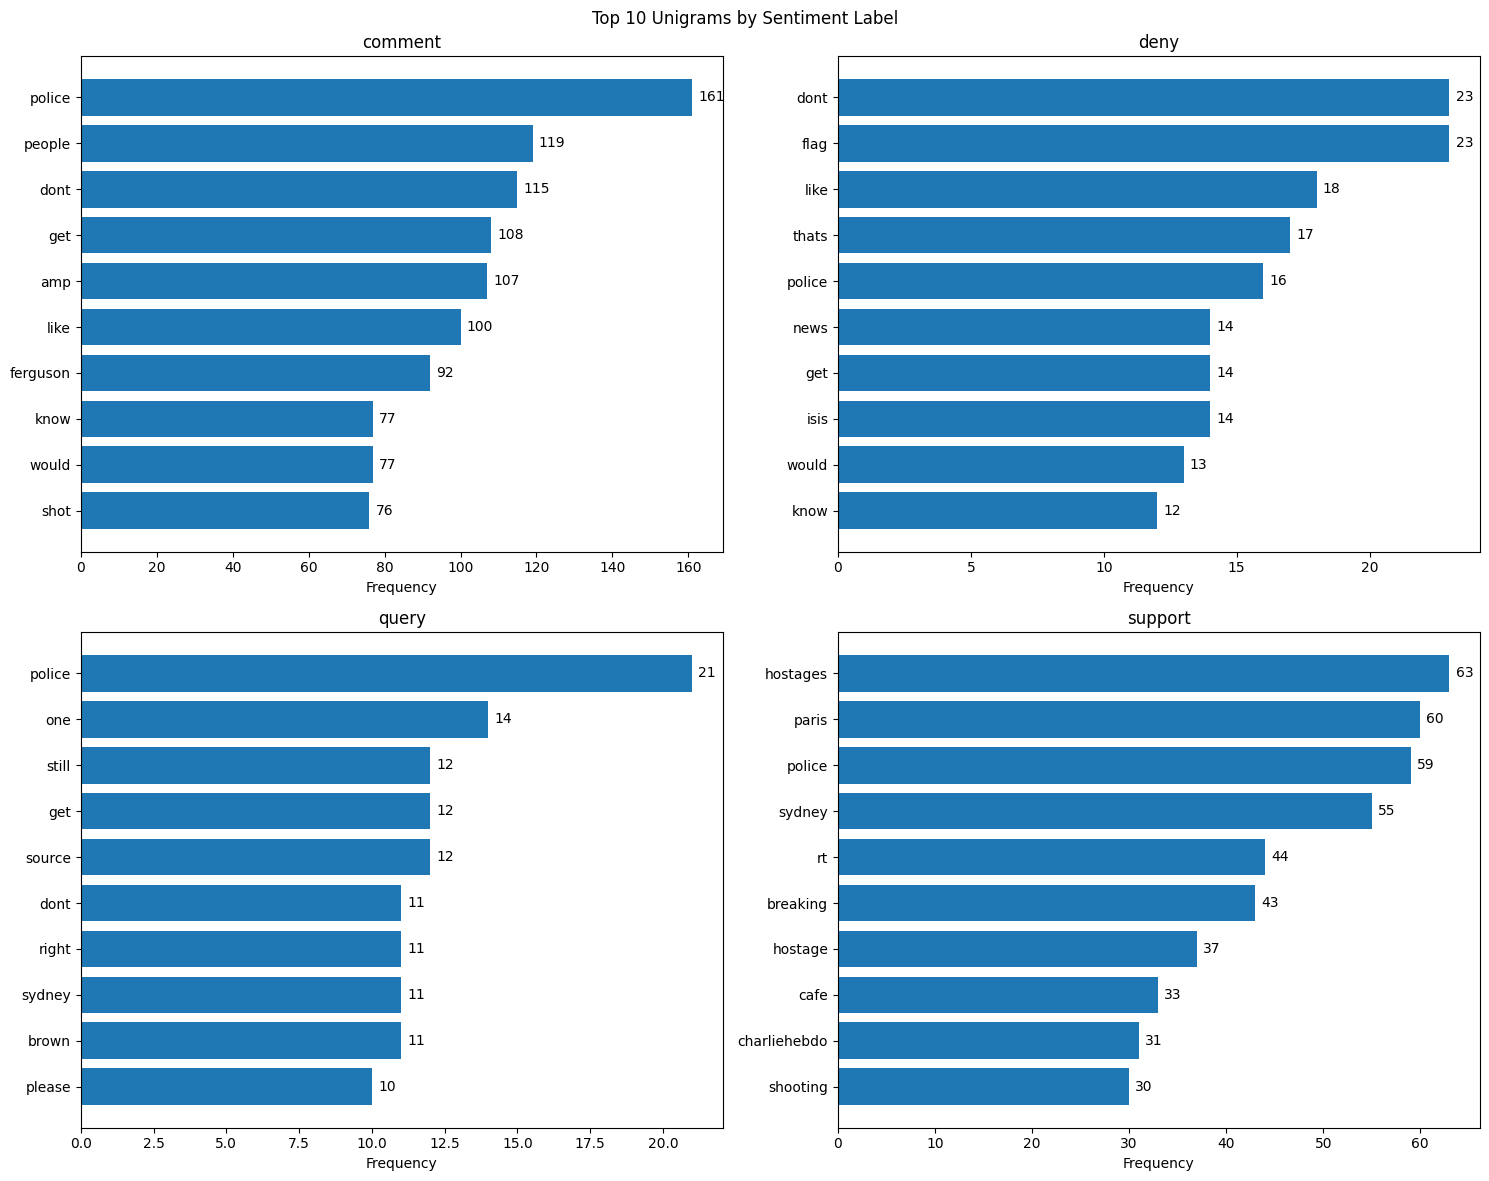

In [202]:
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Top 10 Unigrams by Sentiment Label')
axes = axes.flatten()

for idx, label in enumerate(stance_labels):
    if label in ngram_data['unigrams'] and ngram_data['unigrams'][label]:
        words, freqs = zip(*ngram_data['unigrams'][label][:10])
        ax = axes[idx]
        bars = ax.barh(range(len(words)), freqs)
        ax.set_yticks(range(len(words)))
        ax.set_yticklabels(words)
        ax.invert_yaxis()
        ax.set_xlabel('Frequency')
        ax.set_title(f'{label}')
        
        # Add frequency values on bars
        for bar in bars:
            width = bar.get_width()
            ax.text(width + max(freqs)*0.01, bar.get_y() + bar.get_height()/2, 
                   f'{int(width)}', va='center')

plt.tight_layout()
plt.show()

Bigram breakdown

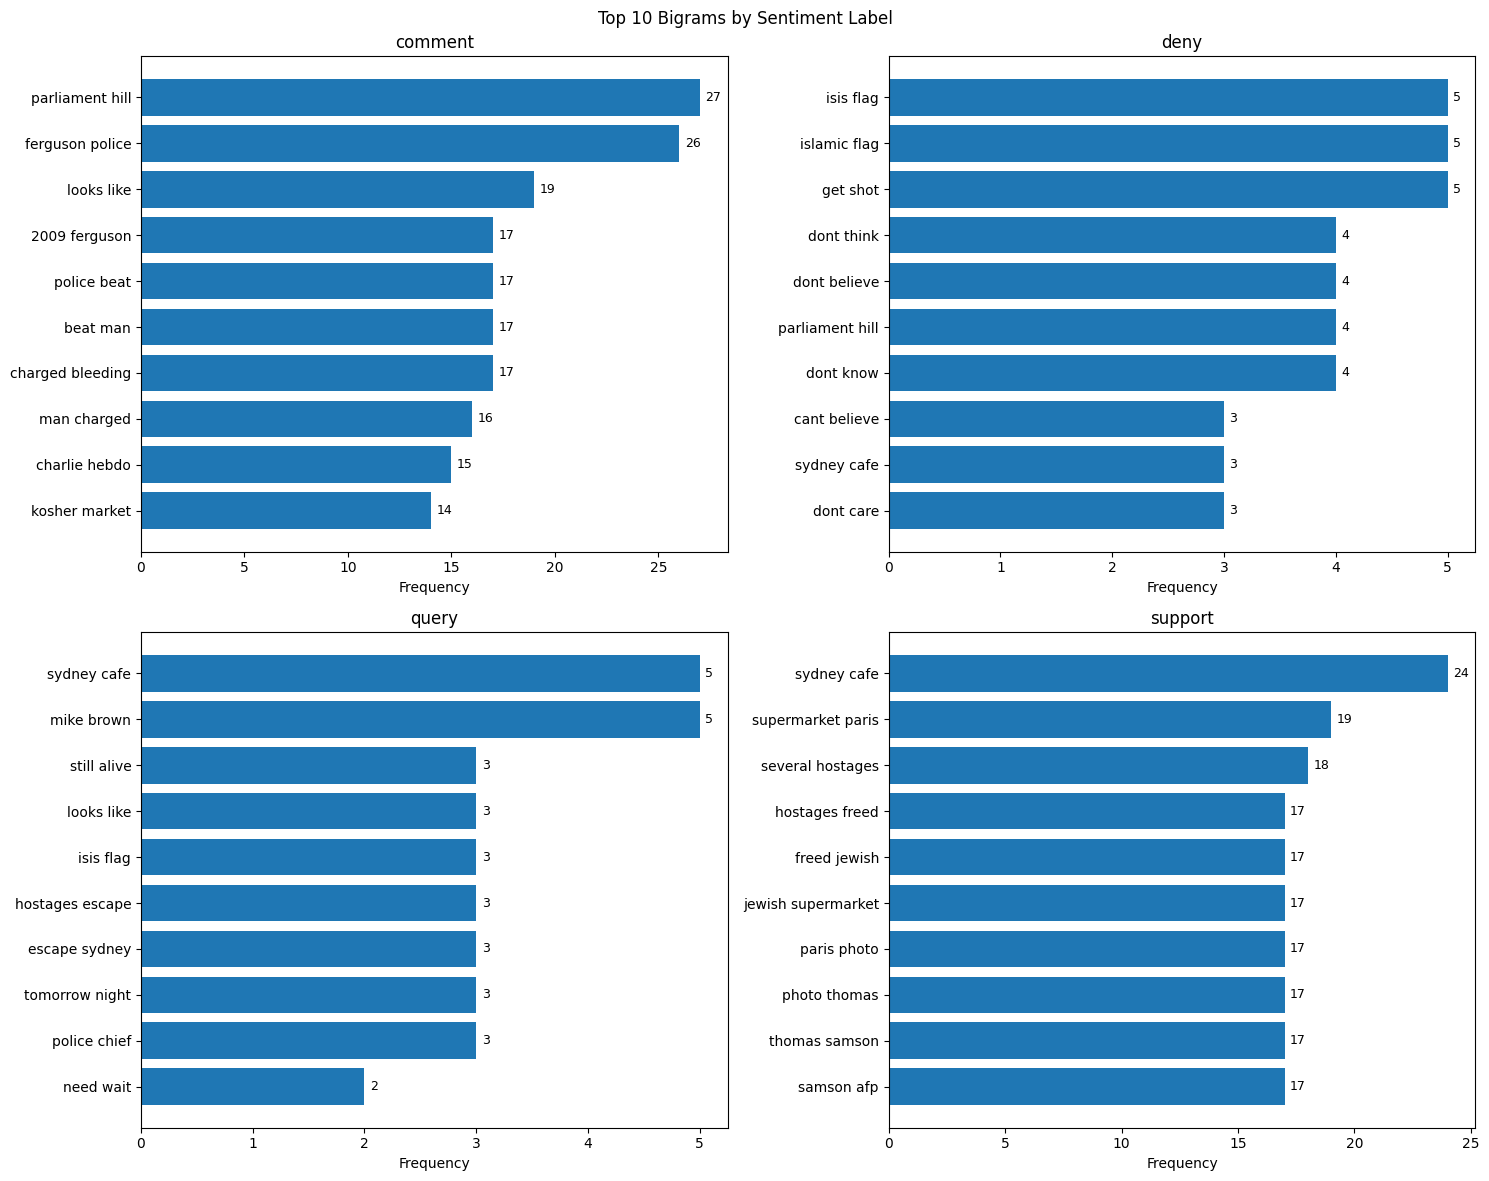

In [203]:
fig2, axes2 = plt.subplots(2, 2, figsize=(15, 12))
fig2.suptitle('Top 10 Bigrams by Sentiment Label')
axes2 = axes2.flatten()

for idx, label in enumerate(stance_labels):
    if label in ngram_data['bigrams'] and ngram_data['bigrams'][label]:
        bigrams, freqs = zip(*ngram_data['bigrams'][label][:10])
        ax = axes2[idx]
        bars = ax.barh(range(len(bigrams)), freqs)
        ax.set_yticks(range(len(bigrams)))
        ax.set_yticklabels(bigrams)
        ax.invert_yaxis()
        ax.set_xlabel('Frequency')
        ax.set_title(f'{label}')
        
        # Add frequency values on bars
        for bar in bars:
            width = bar.get_width()
            ax.text(width + max(freqs)*0.01, bar.get_y() + bar.get_height()/2, 
                   f'{int(width)}', va='center', fontsize=9)

plt.tight_layout()
plt.show()

Get token distribution for stance vs non-stance

For source tweets

In [204]:
unique_sources = df.drop_duplicates(subset=['source_tweet_id']).copy()
unique_sources['is_stance'] = unique_sources['source_tweet_sentiment'].isin(['support', 'deny', 'query'])

stance_source_texts = unique_sources[unique_sources['is_stance']]['processed_source_text'].tolist()
non_stance_source_texts = unique_sources[~unique_sources['is_stance']]['processed_source_text'].tolist()

source_vectorizer = CountVectorizer(
    stop_words=list(stop_words),
    max_features=20,
    ngram_range=(1, 1)
)

all_source_texts = stance_source_texts + non_stance_source_texts
source_vectorizer.fit(all_source_texts)

stance_source_counts = source_vectorizer.transform(stance_source_texts).sum(axis=0)
non_stance_source_counts = source_vectorizer.transform(non_stance_source_texts).sum(axis=0)
feature_names = source_vectorizer.get_feature_names_out()

source_comparison = []
for i, feature in enumerate(feature_names):
    stance_freq = stance_source_counts[0, i]
    non_stance_freq = non_stance_source_counts[0, i]
    
    stance_norm = stance_freq / len(stance_source_texts) if len(stance_source_texts) > 0 else 0
    non_stance_norm = non_stance_freq / len(non_stance_source_texts) if len(non_stance_source_texts) > 0 else 0
    
    source_comparison.append({
        'unigram': feature,
        'stance_freq': stance_freq,
        'non_stance_freq': non_stance_freq,
        'stance_norm': stance_norm,
        'non_stance_norm': non_stance_norm
    })

source_comparison_df = pd.DataFrame(source_comparison)
source_comparison_df['total_freq'] = source_comparison_df['stance_freq'] + source_comparison_df['non_stance_freq']
source_comparison_df = source_comparison_df.sort_values('total_freq', ascending=False)

For reply tweets

In [205]:
df['is_stance_reply'] = df['sentiment'].isin(['support', 'deny', 'query'])
stance_reply_texts = df[df['is_stance_reply']]['processed_text'].tolist()
non_stance_reply_texts = df[~df['is_stance_reply']]['processed_text'].tolist()


reply_vectorizer = CountVectorizer(
    stop_words=list(stop_words),
    max_features=20,
    ngram_range=(1, 1)
)

all_reply_texts = stance_reply_texts + non_stance_reply_texts
reply_vectorizer.fit(all_reply_texts)

stance_reply_counts = reply_vectorizer.transform(stance_reply_texts).sum(axis=0)
non_stance_reply_counts = reply_vectorizer.transform(non_stance_reply_texts).sum(axis=0)
reply_feature_names = reply_vectorizer.get_feature_names_out()

reply_comparison = []
for i, feature in enumerate(reply_feature_names):
    stance_freq = stance_reply_counts[0, i]
    non_stance_freq = non_stance_reply_counts[0, i]
    
    stance_norm = stance_freq / len(stance_reply_texts) if len(stance_reply_texts) > 0 else 0
    non_stance_norm = non_stance_freq / len(non_stance_reply_texts) if len(non_stance_reply_texts) > 0 else 0
    
    reply_comparison.append({
        'unigram': feature,
        'stance_freq': stance_freq,
        'non_stance_freq': non_stance_freq,
        'stance_norm': stance_norm,
        'non_stance_norm': non_stance_norm
    })

reply_comparison_df = pd.DataFrame(reply_comparison)
reply_comparison_df['total_freq'] = reply_comparison_df['stance_freq'] + reply_comparison_df['non_stance_freq']
reply_comparison_df = reply_comparison_df.sort_values('total_freq', ascending=False)

Plot token distribution

For source tweets

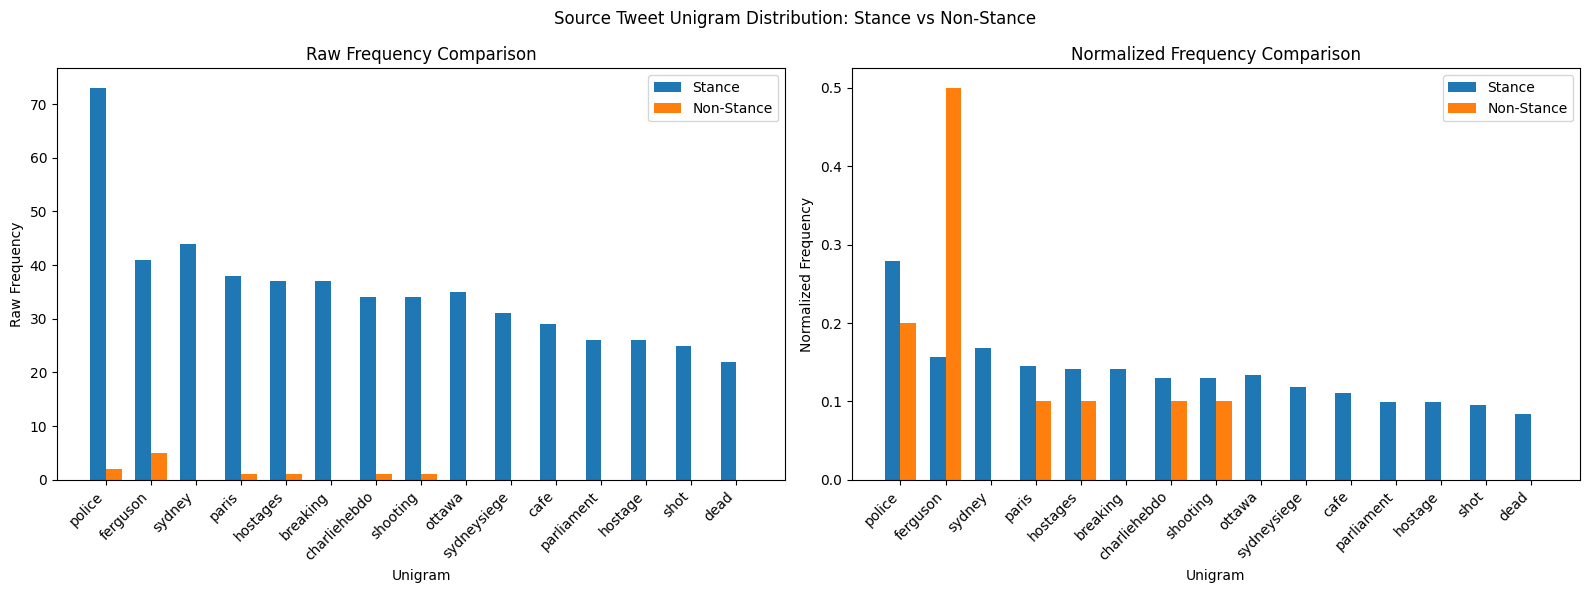

In [206]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
fig.suptitle('Source Tweet Unigram Distribution: Stance vs Non-Stance')

# Raw frequency
top_n = 15
top_source_unigrams = source_comparison_df.head(top_n)['unigram'].values
top_source_stance = source_comparison_df.head(top_n)['stance_freq'].values
top_source_non_stance = source_comparison_df.head(top_n)['non_stance_freq'].values

x = np.arange(len(top_source_unigrams))
width = 0.35

ax1.bar(x - width/2, top_source_stance, width, label='Stance')
ax1.bar(x + width/2, top_source_non_stance, width, label='Non-Stance')
ax1.set_xlabel('Unigram')
ax1.set_ylabel('Raw Frequency')
ax1.set_title('Raw Frequency Comparison')
ax1.set_xticks(x)
ax1.set_xticklabels(top_source_unigrams, rotation=45, ha='right')
ax1.legend()

# Normalized frequency
top_source_stance_norm = source_comparison_df.head(top_n)['stance_norm'].values
top_source_non_stance_norm = source_comparison_df.head(top_n)['non_stance_norm'].values

ax2.bar(x - width/2, top_source_stance_norm, width, label='Stance')
ax2.bar(x + width/2, top_source_non_stance_norm, width, label='Non-Stance')
ax2.set_xlabel('Unigram')
ax2.set_ylabel('Normalized Frequency')
ax2.set_title('Normalized Frequency Comparison')
ax2.set_xticks(x)
ax2.set_xticklabels(top_source_unigrams, rotation=45, ha='right')
ax2.legend()

plt.tight_layout()
plt.show()

For reply tweets

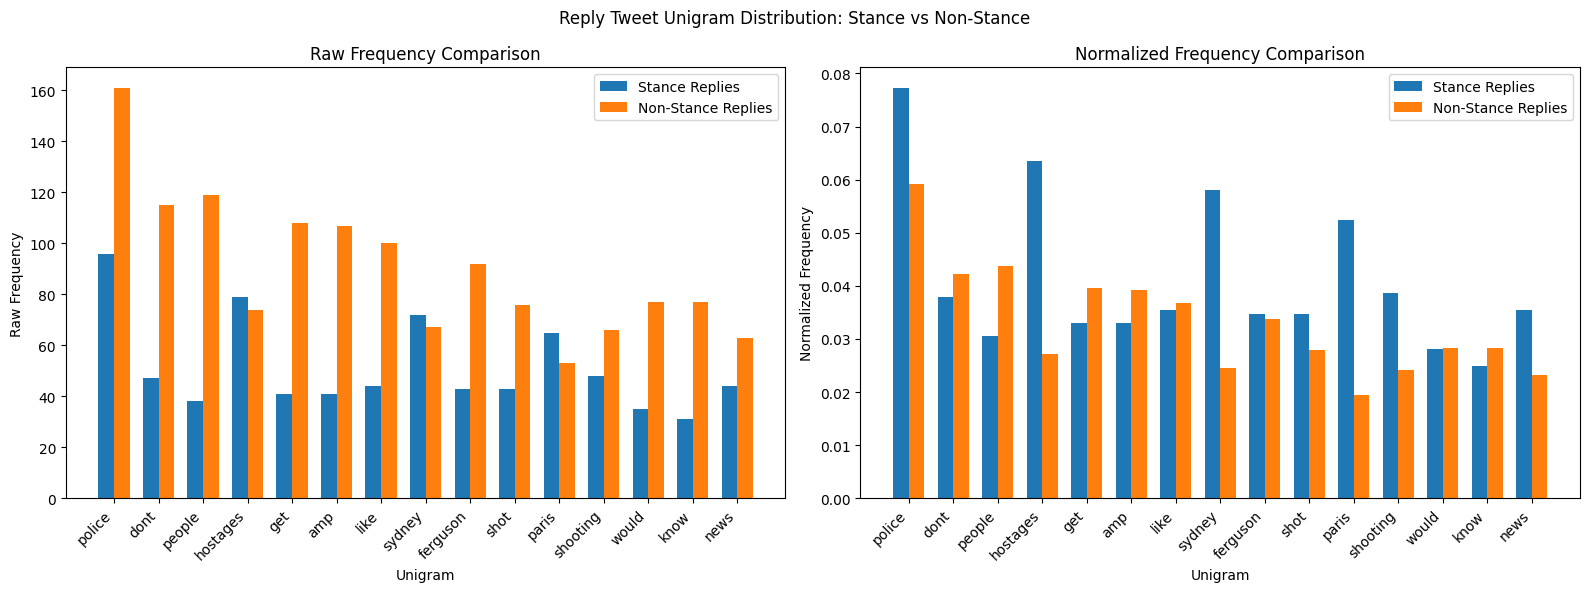

In [207]:
fig, (ax3, ax4) = plt.subplots(1, 2, figsize=(16, 6))
fig.suptitle('Reply Tweet Unigram Distribution: Stance vs Non-Stance')

# Raw frequency
top_reply_unigrams = reply_comparison_df.head(top_n)['unigram'].values
top_reply_stance = reply_comparison_df.head(top_n)['stance_freq'].values
top_reply_non_stance = reply_comparison_df.head(top_n)['non_stance_freq'].values

x_reply = np.arange(len(top_reply_unigrams))

ax3.bar(x_reply - width/2, top_reply_stance, width, label='Stance Replies')
ax3.bar(x_reply + width/2, top_reply_non_stance, width, label='Non-Stance Replies')
ax3.set_xlabel('Unigram')
ax3.set_ylabel('Raw Frequency')
ax3.set_title('Raw Frequency Comparison')
ax3.set_xticks(x_reply)
ax3.set_xticklabels(top_reply_unigrams, rotation=45, ha='right')
ax3.legend()

# Normalized frequency
top_reply_stance_norm = reply_comparison_df.head(top_n)['stance_norm'].values
top_reply_non_stance_norm = reply_comparison_df.head(top_n)['non_stance_norm'].values

ax4.bar(x_reply - width/2, top_reply_stance_norm, width, label='Stance Replies')
ax4.bar(x_reply + width/2, top_reply_non_stance_norm, width, label='Non-Stance Replies')
ax4.set_xlabel('Unigram')
ax4.set_ylabel('Normalized Frequency')
ax4.set_title('Normalized Frequency Comparison')
ax4.set_xticks(x_reply)
ax4.set_xticklabels(top_reply_unigrams, rotation=45, ha='right')
ax4.legend()

plt.tight_layout()
plt.show()

## LDA

# Classification

## 4-way Classification

## Model Prompting

## Chain of thought